## Challenge 1

I have choosing challenge 1, because it seems like the more fun dataset to test and play around.
* First I load all necessary packages and helper functions
* Second loading the data and clean it if necessary
* Third exploring the data and look for patterns
* Fourth model the data in order to create a anaomaly detection system, which igores gapes in the data

In [41]:
# loading all packages
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import optuna 
from optuna.samplers import TPESampler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score,precision_recall_fscore_support,accuracy_score
from sklearn.metrics import roc_curve
from catboost import CatBoostClassifier
from sklearn.linear_model import LassoCV
from sklearn.decomposition import PCA
from statsmodels.graphics.tsaplots import plot_acf

In [57]:
# defining all necessary helper functions
## define functions for missings
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()
    
    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    
    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    
    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    
    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    
    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
    
    # Return the dataframe with missing information
    return mis_val_table_ren_columns

def analyse_cats(df, cat_cols):
    d = pd.DataFrame()
    cl = [];u = [];s =[]; nans =[]
    for c in cat_cols:
        #print("column:" , c ,"--Uniques:" , train[c].unique(), "--Cardinality:", train[c].unique().size)
        cl.append(c); u.append(df[c].unique());s.append(df[c].unique().size);nans.append(df[c].isnull().sum())
        
    d['"feat"'] = cl;d["uniques"] = u; d["cardinality"] = s; d["nans"] = nans
    return d

# color the cells based on their value for the describe function
def color_negative_red(val):
    color = 'red' if val < 0 else 'black'
    return 'color: %s' % color
    
# plot VIF values to check for multicolinarity
def vif_plot(X):
    vifs = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
    feature_orig = list(X.columns)
    plt.figure(figsize=(6, 4))
    plt.bar(feature_orig, vifs, color='green')
    plt.title('VIF values of features')
    plt.xlabel('Features')
    plt.ylabel('VIF')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()  


# Create split data function
def split_data(data: pd.DataFrame, test_size: float,target_col:float) -> tuple:
    
    """Split the data into training and test sets.
    Args:
        data: pd.DataFrame: the data to be split.
        test_size: float: the proportion of data to be used for testing.
        target_column: float: Column used for regression
    Returns:
        X_train: pd.DataFrame: the training data.
        X_test: pd.DataFrame: the test data.
        y_train: pd.DataFrame: the training labels.
        y_test: pd.DataFrame: the test labels.
    """
    target = data[target_col]
    features = data.drop(target_col, axis=1)
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=test_size, random_state=42,stratify=target)
    return X_train, X_test, y_train, y_test

# Create preprocess function
def preprocess_data(X_train: pd.DataFrame, X_test: pd.DataFrame) -> tuple:
  
    """Preprocess the data.
    Args:
        X_train: pd.DataFrame: the training data.  
        X_test: pd.DataFrame: the test data.
        
    Returns:
        X_train: pd.DataFrame: the preprocessed training data.
        X_test: pd.DataFrame: the preprocessed test data.
    """
    num_features = X_train.select_dtypes(exclude='object').columns
    
    # pipeline
    numerical_transformer = Pipeline(steps=[
        ('standard', StandardScaler())
    ])
    
   # cat_transformer = Pipeline(steps=[
       # ('imputing_cat', CategoricalImputer(imputation_method='frequent'))
   # ])
    
    preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_features)
       # ('cat', cat_transformer, cat_features)
    ])
    X_train_prep = preprocessor.fit_transform(X_train)
    X_test_prep = preprocessor.transform(X_test)

    X_train_prep = pd.DataFrame(X_train_prep)
    X_test_prep = pd.DataFrame(X_test_prep)
    
    return X_train_prep, X_test_prep, preprocessor

# Plot the roc curve for the last fold
def plot_roc_curve(y_va, y_va_pred):
    plt.figure(figsize=(8, 8))
    fpr, tpr, _ = roc_curve(y_va, y_va_pred)
    plt.plot(fpr, tpr, color='r', lw=2)
    plt.plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--")
    plt.gca().set_aspect('equal')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic")
    plt.show()

# optuna modelm
def optuna_model(X:pd.DataFrame, y:pd.Series, n_trial:int, splits:int):
    
    # internal train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    kf = StratifiedKFold(n_splits=splits, random_state=42, shuffle=True)

    #create a imbalance ratio to extreme imbalanced target class
    imbalance_ratio = sum(y_train)/(len(y_train)-sum(y_train))
    
    # CatBoost Model
    def cat_objective(trial):
        params = {
                'eval_metric': 'AUC',
                'loss_function': 'Logloss',
                'random_seed': 42,
                'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05),
                'depth': trial.suggest_int('depth', 4, 10),
                'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10, log=True),
                'border_count': trial.suggest_int('border_count', 32, 255),
                'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 10),
                'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
                'random_strength': trial.suggest_float('random_strength', 0, 10),
                'iterations': trial.suggest_int('iterations', 100, 5000),
                'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bayesian']),
                'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
                'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations', 1, 10),
                'scale_pos_weight':imbalance_ratio
        }
        
        classifier = CatBoostClassifier(**params)
        aucs = []
        for train_index, test_index in kf.split(X, y):
            classifier.fit(X.iloc[train_index], y.iloc[train_index], eval_set = [(X.iloc[test_index] , y.iloc[test_index])])
            preds = classifier.predict_proba(X.iloc[test_index])
            auc = roc_auc_score(y.iloc[test_index], preds[:,1])
            aucs.append(auc)
        
        print(f'Trial done: AUC values on folds: {aucs}')
        return np.mean(aucs)

    cat_study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), 
                                    sampler=optuna.samplers.TPESampler(), direction="maximize")
    cat_study.optimize(cat_objective, n_trials=n_trial)
    
    cat_params = cat_study.best_trial.params
    cat_params['eval_metric'] = 'AUC'
    cat_params['loss_function'] = 'Logloss'
    cat_params['random_seed'] = 42

    classifier = CatBoostClassifier(**cat_params)
    classifier.fit(X_train, y_train, eval_set = [(X_test , y_test)])
    
    return classifier

In [187]:
# load the data
df = pd.read_csv('sample_temperature_data_for_coding_challenge.csv')

In [188]:
# show the data
df.head(3)

,source_id,datetime,property_name,temperature
0,MICDEV001,2019-04-13T17:51:16.000+0000,heating_temperature,33.3
1,MICDEV001,2019-04-13T17:51:16.000+0000,cooling_temperature,15.0
2,MICDEV001,2019-04-13T18:51:18.000+0000,heating_temperature,34.0


In [189]:
# take a look at the shape
df.shape

(1000, 4)

In [190]:
# check for occurence of property names
df.property_name.value_counts()

property_name
heating_temperature    699
cooling_temperature    301
Name: count, dtype: int64

In [191]:
# describe the data set
df.describe().T.style.background_gradient()

,count,mean,std,min,25%,50%,75%,max
temperature,1000.000000,29.529700,7.132047,14.900000,24.775000,32.900000,34.500000,39.400000


In [192]:
# check for types
df.dtypes

source_id         object
datetime          object
property_name     object
temperature      float64
dtype: object

In [193]:
# check for missings
missing_values_table(df)

Your selected dataframe has 4 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [194]:
# check for possible categorical columns
plt.style.use('fivethirtyeight')
catanadf = analyse_cats(df, df.columns)
catanadf

,"""feat""",uniques,cardinality,nans
0,source_id,[MICDEV001],1,0
1,datetime,"[2019-04-13T17:51:16.000+0000, 2019-04-13T18:5...",716,0
2,property_name,"[heating_temperature, cooling_temperature]",2,0
3,temperature,"[33.3, 15.0, 34.0, 33.8, 34.2, 34.5, 34.7, 34....",172,0


In [195]:
# how many different devices are there?
df.source_id.value_counts()

source_id
MICDEV001    1000
Name: count, dtype: int64

In [205]:
# create time series
df['datetime'] = pd.to_datetime(df['datetime'])
df['date'] = df['datetime'].dt.date
df['month'] = df['datetime'].dt.month
df['weekday'] = df['datetime'].dt.weekday
df['hour'] = df['datetime'].dt.hour

# Show new data set
df.head(3)

,source_id,datetime,property_name,temperature,date,month,weekday,hour
0,MICDEV001,2019-04-13 17:51:16+00:00,heating_temperature,33.3,2019-04-13,4,5,17
1,MICDEV001,2019-04-13 17:51:16+00:00,cooling_temperature,15.0,2019-04-13,4,5,17
2,MICDEV001,2019-04-13 18:51:18+00:00,heating_temperature,34.0,2019-04-13,4,5,18


In [125]:
# Group by source_id and date and count the number of readings per group
readings_per_day_per_property = df.groupby(['source_id', 'date','property_name']).size().reset_index(name='readings_count')

# Display the first few rows of the result
readings_per_day_per_property.head(15)

,source_id,date,property_name,readings_count
0,MICDEV001,2019-04-13,cooling_temperature,1
1,MICDEV001,2019-04-13,heating_temperature,7
2,MICDEV001,2019-04-14,cooling_temperature,11
3,MICDEV001,2019-04-14,heating_temperature,19
4,MICDEV001,2019-04-15,cooling_temperature,4
5,MICDEV001,2019-04-15,heating_temperature,20
6,MICDEV001,2019-04-16,cooling_temperature,2
7,MICDEV001,2019-04-16,heating_temperature,12
8,MICDEV001,2019-04-17,cooling_temperature,4
9,MICDEV001,2019-04-17,heating_temperature,5


In [211]:
# Check if there are days without heating temps, when cooling temps are present
heating_data = df[df['property_name'] == 'heating_temperature'].groupby('date').max()
cooling_data = df[df['property_name'] == 'cooling_temperature'].groupby('date').max()
days_with_cooling_only = cooling_data.index.difference(heating_data.index)
days_with_cooling_only

Index([], dtype='object', name='date')

In [213]:
# create cooling and heating dataset
df_heating = df[df['property_name'] == 'heating_temperature']
df_cooling = df[df['property_name'] == 'cooling_temperature']
df_heating['datetime'] = pd.to_datetime(df_heating['datetime'])
df_cooling['datetime'] = pd.to_datetime(df_cooling['datetime'])

# Create a set of tuples
heating_dates = set(zip(df_heating['source_id'], df_heating['datetime']))

# Count how many cooling temperatures dont match
non_matching_cooling_temps = sum((row['source_id'], row['datetime']) not in heating_dates for index, row in df_cooling.iterrows())

non_matching_cooling_temps

17

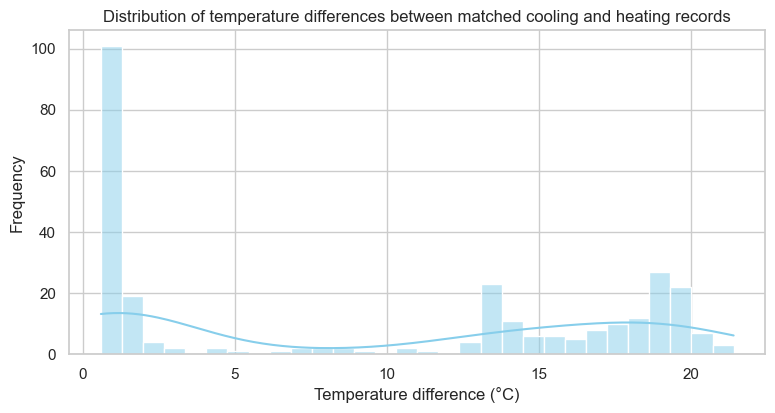

In [218]:
import matplotlib.pyplot as plt
import seaborn as sns

matched_temps = pd.merge(df_cooling, df_heating, on=['source_id', 'datetime'], suffixes=('_cooling', '_heating'))

# Calculate the temperature difference between each matched cooling and heating temperature
matched_temps['temp_difference'] = matched_temps['temperature_heating'] - matched_temps['temperature_cooling']
# Set the style of seaborn
sns.set(style="whitegrid")

# Create a distribution plot for the temperature differences
plt.figure(figsize=(8, 4))
sns.histplot(matched_temps['temp_difference'], kde=True, bins=30, color='skyblue')
plt.title('Distribution of temperature differences between matched cooling and heating records')
plt.xlabel('Temperature difference (°C)')
plt.ylabel('Frequency')

plt.show()

In [222]:
# temp difference for each hour
matched_temps.groupby("hour_heating").temp_difference.describe()

,count,mean,std,min,25%,50%,75%,max
hour_heating,,,,,,,,
7,2.0,0.900000,2.512148e-15,0.9,0.900,0.90,0.900,0.9
8,15.0,2.866667,4.371117e+00,0.8,1.050,1.10,1.400,13.7
9,38.0,5.702632,6.545000e+00,0.7,1.000,1.15,13.275,19.8
10,38.0,11.460526,7.110196e+00,0.8,1.400,14.10,16.250,20.6
11,27.0,8.607407,7.370415e+00,0.8,1.100,8.50,15.550,19.7
12,23.0,11.017391,8.151779e+00,0.6,1.150,15.20,18.100,19.6
13,20.0,10.135000,8.306831e+00,0.7,1.400,10.45,18.800,21.0
14,26.0,8.653846,8.363312e+00,0.7,1.000,2.10,17.450,19.5
15,29.0,11.134483,8.471603e+00,0.8,1.100,15.70,19.200,20.2


## First Impressions

* There are 1000 entries for one devices over several month with several readings per day.
* The readings for each property name are not constant and different for both groups, there are also several gaps between days.
* Most of the cooling readings have heating reading in the same hour, only 17 do not match, therefore for anomaly modeling we could generate 17 more heating events with those cooling events and add the mean difference of the specific hour.
* The next steps will be to look up the distribution of temperature readings aswell as variances of month, week, hour as well as the auto correlation of heating and cooling. I will test for homoscedacity aswell as stationarity of the time series in order to creat 

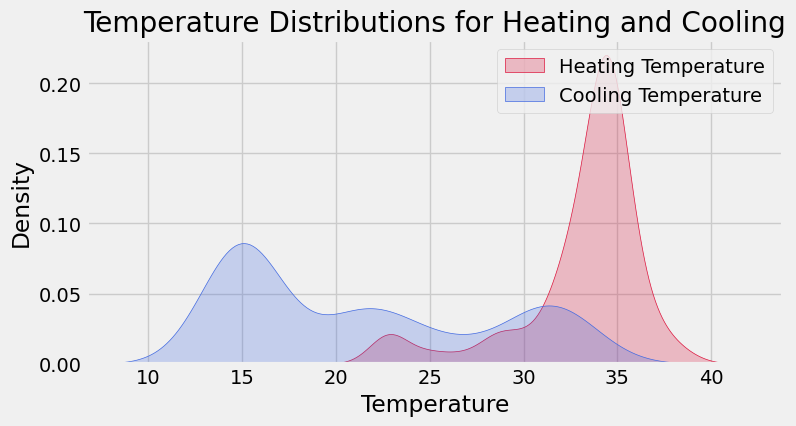

In [152]:
# Plot densities of both types of temperature properties
heating_df = df[df['property_name'] == 'heating_temperature']['temperature']
cooling_df = df[df['property_name'] == 'cooling_temperature']['temperature']

plt.figure(figsize=(8, 4))  

# create density plot
sns.kdeplot(heating_df, label='Heating Temperature', fill=True,color='crimson')  
sns.kdeplot(cooling_df, label='Cooling Temperature', fill=True,color='royalblue')  

plt.title('Temperature Distributions for Heating and Cooling')
plt.xlabel('Temperature')
plt.ylabel('Density')
plt.legend()
plt.show()

## Temperature anomalies

* We can observe anomilies for the heating temperature, if we account for the fact that most observation are between 30 and 35 degrees.
* While observations for cooling are all over the place

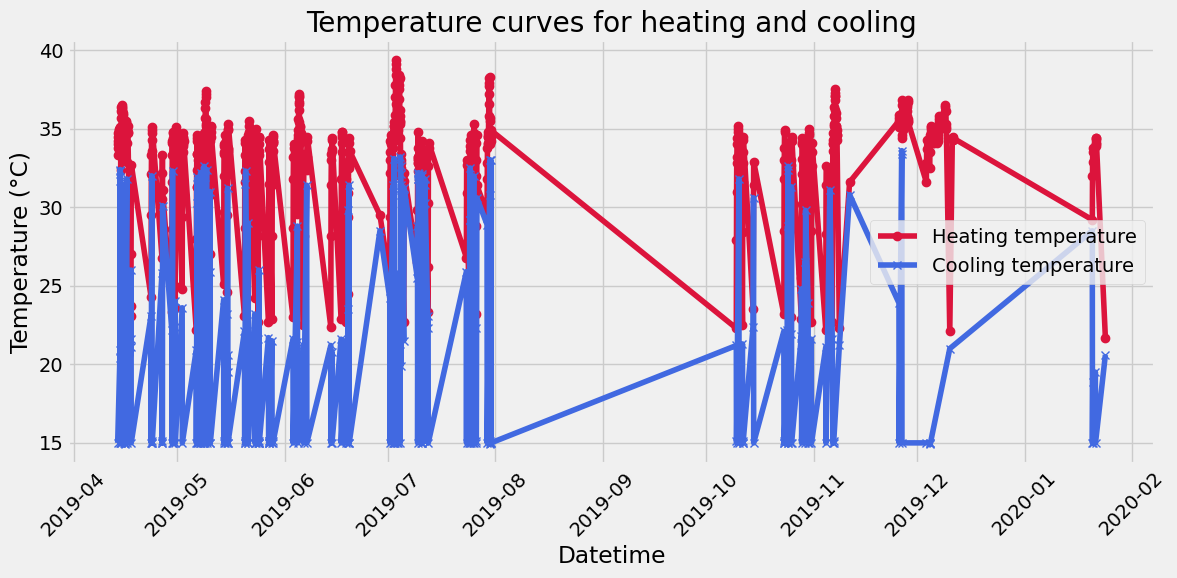

In [156]:
# Filtering and averaging temperatures
heating_temps = df[df['property_name'] == 'heating_temperature'].groupby('datetime')['temperature'].mean()
cooling_temps = df[df['property_name'] == 'cooling_temperature'].groupby('datetime')['temperature'].mean()

# PLot timeseries
plt.figure(figsize=(12, 6))
plt.plot(heating_temps.index, heating_temps, label='Heating temperature', marker='o',color='crimson')
plt.plot(cooling_temps.index, cooling_temps, label='Cooling temperature', marker='x',color='royalblue')
plt.xlabel('Datetime')
plt.ylabel('Temperature (°C)')
plt.title('Temperature curves for heating and cooling')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

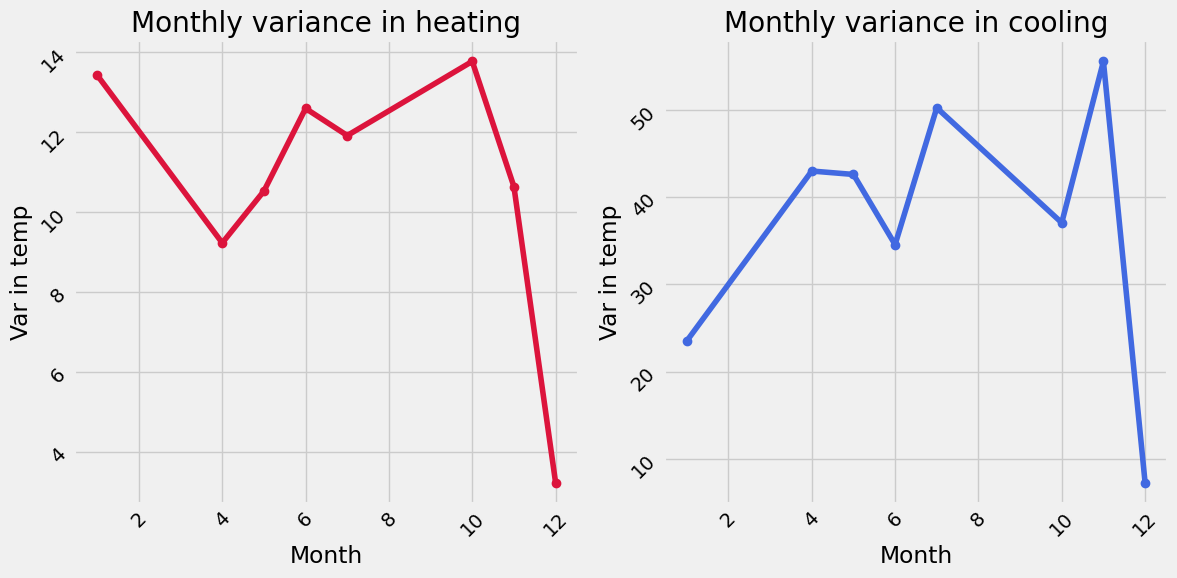

In [173]:
### variance plot for month
heating_data = df[df['property_name'] == 'heating_temperature']
cooling_data = df[df['property_name'] == 'cooling_temperature']

# get variance hour
monthly_temp_variance_heat = heating_data.groupby('month')['temperature'].var().reset_index()
monthly_temp_variance_cool = cooling_data.groupby('month')['temperature'].var().reset_index()

# create esubplot
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharex=True)

# heating plot
axs[0].plot(monthly_temp_variance_heat['month'], monthly_temp_variance_heat['temperature'], marker='o', linestyle='-', color='crimson')
axs[0].set_title('Monthly variance in heating')
axs[0].set_xlabel('Month')
axs[0].set_ylabel('Var in temp')
axs[0].tick_params(labelrotation=45)

# cooling plot
axs[1].plot(monthly_temp_variance_cool['month'], monthly_temp_variance_cool['temperature'], marker='o', linestyle='-', color='royalblue')
axs[1].set_title('Monthly variance in cooling')
axs[1].set_xlabel('Month')
axs[1].set_ylabel('Var in temp')
axs[1].tick_params(labelrotation=45)

plt.tight_layout()
plt.show()

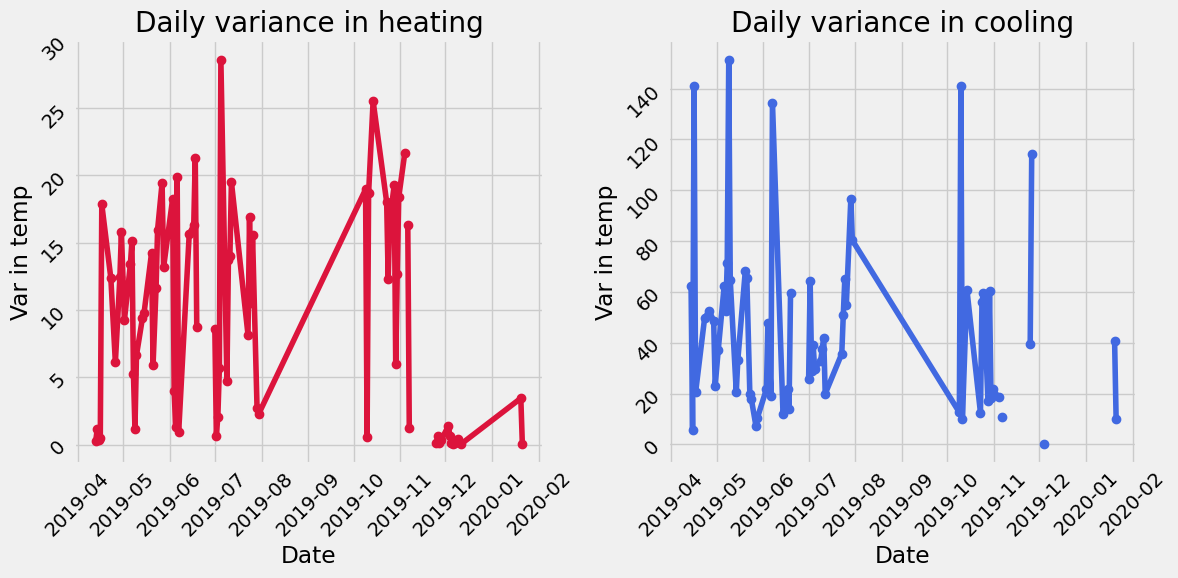

In [170]:
### variance plot for days
heating_data = df[df['property_name'] == 'heating_temperature']
cooling_data = df[df['property_name'] == 'cooling_temperature']

# get variance day
daily_temp_variance_heat = heating_data.groupby('date')['temperature'].var().reset_index()
daily_temp_variance_cool = cooling_data.groupby('date')['temperature'].var().reset_index()

# get variance hour
hourly_temp_variance_heat = heating_data.groupby('hour')['temperature'].var().reset_index()
hourly_temp_variance_cool = cooling_data.groupby('hour')['temperature'].var().reset_index()

# create subplot
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharex=True)

# variance plots
axs[0].plot(daily_temp_variance_heat['date'], daily_temp_variance_heat['temperature'], marker='o', linestyle='-', color='crimson')
axs[0].set_title('Daily variance in heating')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Var in temp')
axs[0].tick_params(labelrotation=45)

axs[1].plot(daily_temp_variance_cool['date'], daily_temp_variance_cool['temperature'], marker='o', linestyle='-', color='royalblue')
axs[1].set_title('Daily variance in cooling')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Var in temp')
axs[1].tick_params(labelrotation=45)

plt.tight_layout()
plt.show()

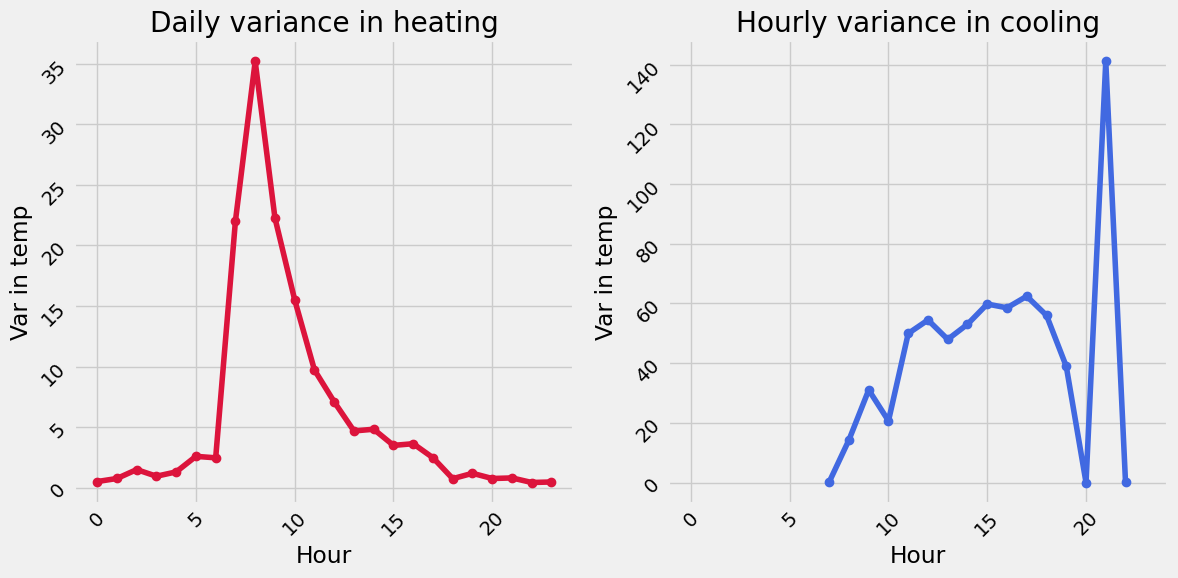

In [182]:
### variance plot for hours
heating_data = df[df['property_name'] == 'heating_temperature']
cooling_data = df[df['property_name'] == 'cooling_temperature']

# get variance hour
hourly_temp_variance_heat = heating_data.groupby('hour')['temperature'].var().reset_index()
hourly_temp_variance_cool = cooling_data.groupby('hour')['temperature'].var().reset_index()

# create esubplot
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharex=True)

# heating plot
axs[0].plot(hourly_temp_variance_heat['hour'], hourly_temp_variance_heat['temperature'], marker='o', linestyle='-', color='crimson')
axs[0].set_title('Daily variance in heating')
axs[0].set_xlabel('Hour')
axs[0].set_ylabel('Var in temp')
axs[0].tick_params(labelrotation=45)

# cooling plot
axs[1].plot(hourly_temp_variance_cool['hour'], hourly_temp_variance_cool['temperature'], marker='o', linestyle='-', color='royalblue')
axs[1].set_title('Hourly variance in cooling')
axs[1].set_xlabel('Hour')
axs[1].set_ylabel('Var in temp')
axs[1].tick_params(labelrotation=45)

plt.tight_layout()
plt.show()

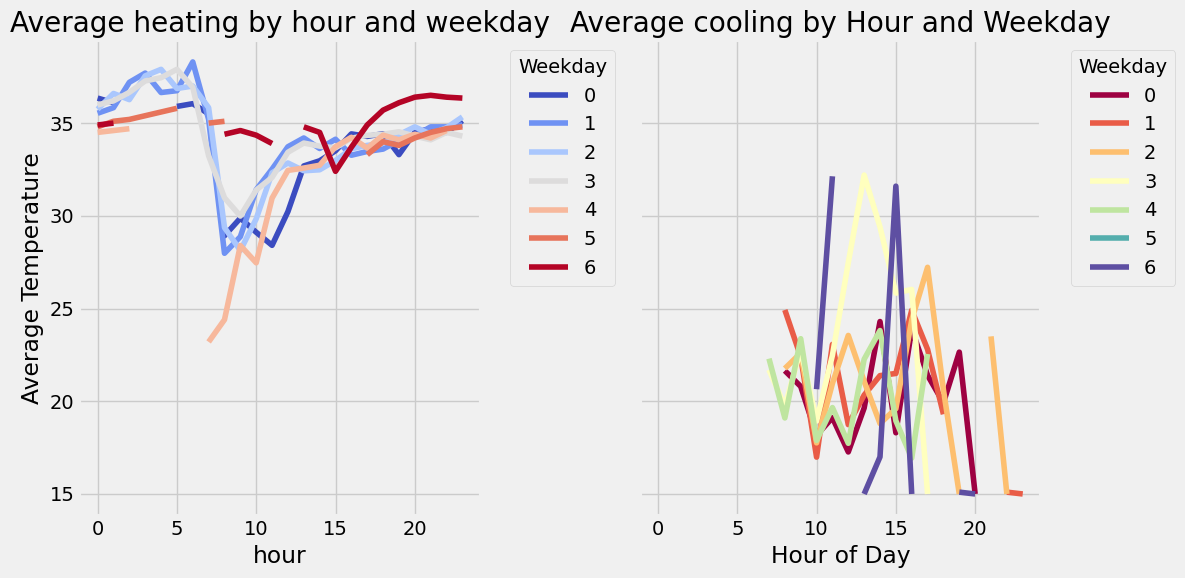

In [201]:
# Grouping for plots
heating_temp_by_hour_weekday = df[df['property_name'] == 'heating_temperature'].groupby(['hour', 'weekday'])['temperature'].mean().unstack()
cooling_temp_by_hour_weekday = df[df['property_name'] == 'cooling_temperature'].groupby(['hour', 'weekday'])['temperature'].mean().unstack()

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

# Plot temperature
heating_temp_by_hour_weekday.plot(ax=axs[0], colormap='coolwarm', title='Average heating by hour and weekday')
cooling_temp_by_hour_weekday.plot(ax=axs[1], colormap='Spectral', title='Average cooling by Hour and Weekday')

# Setting labels
axs[0].set_ylabel('Average Temperature')
axs[1].set_ylabel('Average Temperature')
axs[1].set_xlabel('Hour of Day')

# Legends and layout
axs[0].legend(title='Weekday', bbox_to_anchor=(1.05, 1), loc='upper left')
axs[1].legend(title='Weekday', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

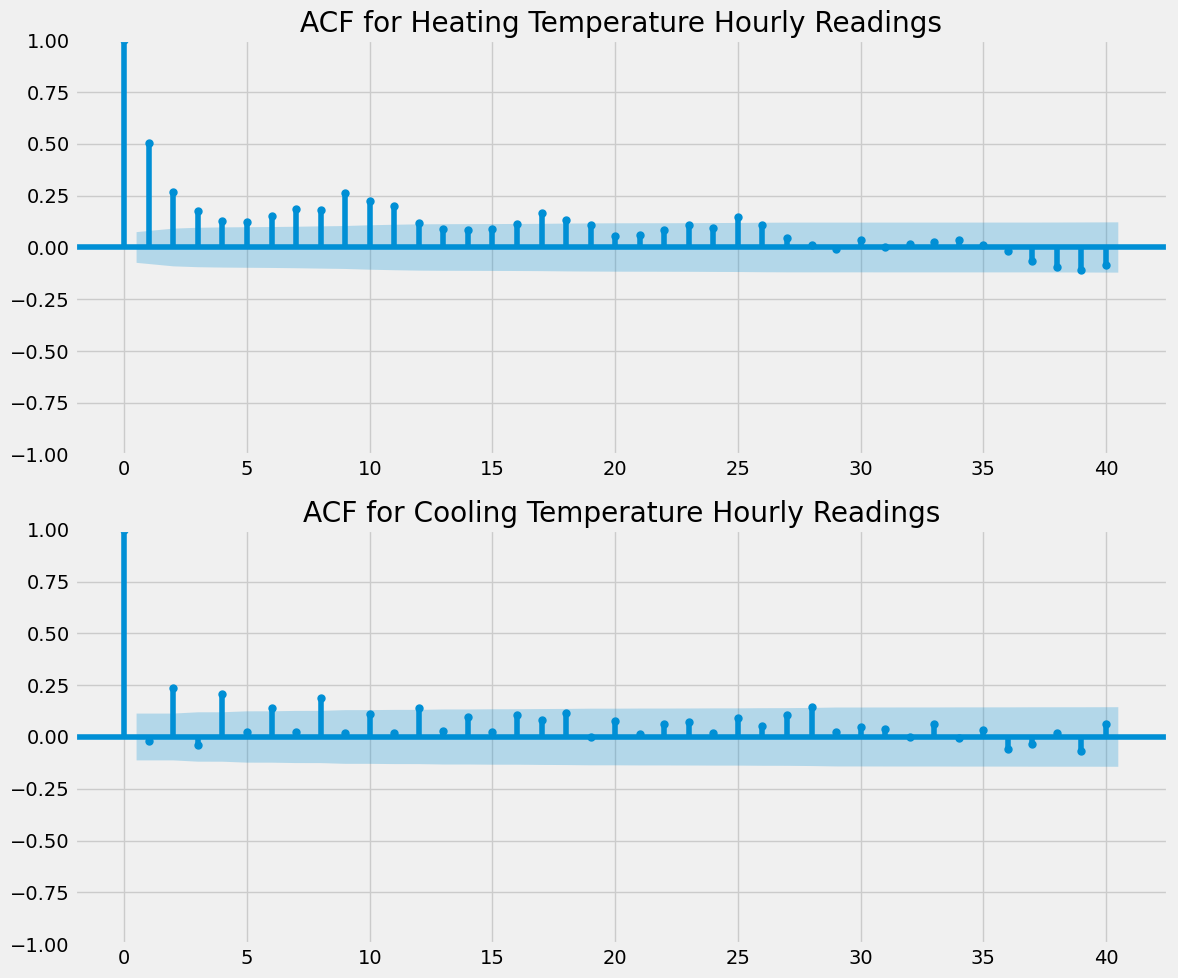

In [186]:
# For this analysis, we need to ensure our data is ordered by datetime and then by hour for each temperature type
heating_data_hourly = df[df['property_name'] == 'heating_temperature'].sort_values(by='datetime')
cooling_data_hourly = df[df['property_name'] == 'cooling_temperature'].sort_values(by='datetime')

# drop nas
heating_data_hourly = heating_data_hourly.dropna(subset=['temperature'])
cooling_data_hourly = cooling_data_hourly.dropna(subset=['temperature'])

# Setting up the figure for ACF plots
fig, axs = plt.subplots(2, 1, figsize=(12, 10))

# ACF plot for Heating Temperature
plot_acf(heating_data_hourly['temperature'], ax=axs[0], lags=40, title='ACF for Heating Temperature Hourly Readings')

# ACF plot for Cooling Temperature
plot_acf(cooling_data_hourly['temperature'], ax=axs[1], lags=40, title='ACF for Cooling Temperature Hourly Readings')

plt.tight_layout()
plt.show()

In [178]:
##
import warnings
warnings.filterwarnings("ignore")
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.api import OLS, add_constant

# Assigning a numerical value to each unique day
unique_days = daily_temp_variance_heat['date'].unique()
day_to_numeric = {day: i for i, day in enumerate(unique_days)}
heating_data_day['date_numeric'] = heating_data_day['date'].map(day_to_numeric)

# Preparing independent (X) and dependent (Y) variables
X_days = add_constant(heating_data_day['date_numeric'])
Y_temp = heating_data_day['temperature']

# Fit regression model for days vs temperature
model_days = OLS(Y_temp, X_days).fit()

# Perform Breusch-Pagan test for days vs temperature
bp_test_days = het_breuschpagan(model_days.resid, model_days.model.exog)

print(bp_test_days)

# Assigning a numerical value to each unique day
unique_days = hourly_temp_variance_cool['hour'].unique()
day_to_numeric = {day: i for i, day in enumerate(unique_days)}
cooling_data_day['hour_numeric'] = cooling_data_day['hour'].map(day_to_numeric)

# Preparing independent (X) and dependent (Y) variables
X_days = add_constant(cooling_data_day['hour_numeric'])
Y_temp = cooling_data_day['temperature']

# Fit regression model for days vs temperature
model_days = OLS(Y_temp, X_days).fit()

# Perform Breusch-Pagan test for days vs temperature
bp_test_days = het_breuschpagan(model_days.resid, model_days.model.exog)

print(bp_test_days)

# Assigning a numerical value to each unique day
unique_days = monthly_temp_variance_cool['month'].unique()
day_to_numeric = {day: i for i, day in enumerate(unique_days)}
cooling_data_day['month_numeric'] = cooling_data_day['month'].map(day_to_numeric)

# Preparing independent (X) and dependent (Y) variables
X_days = add_constant(cooling_data_day['month_numeric'])
Y_temp = cooling_data_day['temperature']

# Fit regression model for days vs temperature
model_days = OLS(Y_temp, X_days).fit()

# Perform Breusch-Pagan test for days vs temperature
bp_test_days = het_breuschpagan(model_days.resid, model_days.model.exog)

print(bp_test_days)

(0.07996519128174273, 0.7773445880103482, 0.07974551529148574, 0.7777264115424547)
(21.844774106885293, 2.9562062829998045e-06, 23.397690073907373, 2.11247425259533e-06)
(2.6427351226553646, 0.10402431550752644, 2.6484282258010343, 0.10470562840035846)


## Brief summary of exploration

* Month and week data show no heteroscedacity.
* The series itself is stationary and therefore controlling for autocorrelation and the 24 hour cycle should be enough to catch outliers
* 

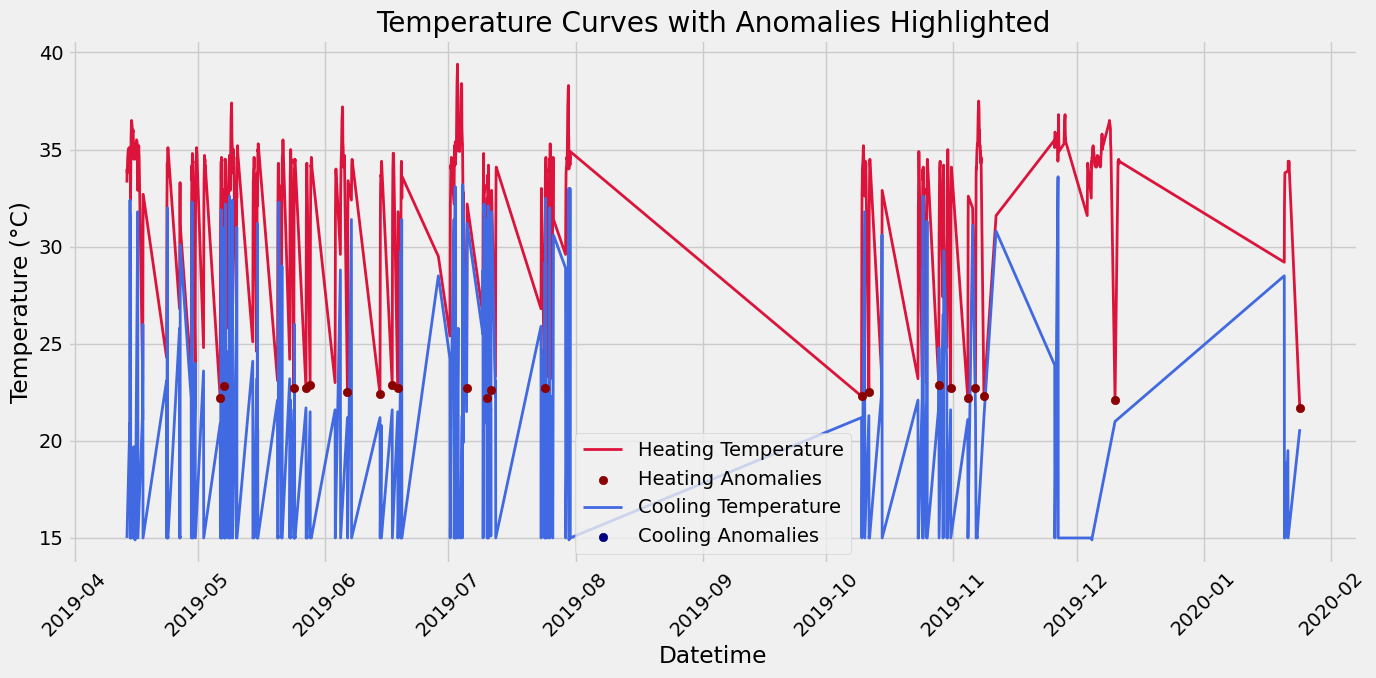

(22, 0)

In [19]:
# get z score
df['z_score'] = df.groupby('property_name')['temperature'].transform(lambda x: zscore(x, ddof=1))

# get anomolies
anomaly_threshold = 3

# mark anomilies
df['is_anomaly'] = df['z_score'].abs() > anomaly_threshold

# Filter anomalies for both categories
heating_anomalies = df[(df['property_name'] == 'heating_temperature') & (df['is_anomaly'])]
cooling_anomalies = df[(df['property_name'] == 'cooling_temperature') & (df['is_anomaly'])]

# Plotting with anomalies 
plt.figure(figsize=(14, 7))
plt.plot(heating_temps.index, heating_temps, label='Heating Temperature', color='crimson', linestyle='-', linewidth=2)
plt.scatter(heating_anomalies['datetime'], heating_anomalies['temperature'], color='darkred', label='Heating Anomalies', zorder=5)
plt.plot(cooling_temps.index, cooling_temps, label='Cooling Temperature', color='royalblue', linestyle='-', linewidth=2)
plt.scatter(cooling_anomalies['datetime'], cooling_anomalies['temperature'], color='navy', label='Cooling Anomalies', zorder=5)
plt.xlabel('Datetime')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Curves with Anomalies Highlighted')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


len(heating_anomalies), len(cooling_anomalies)

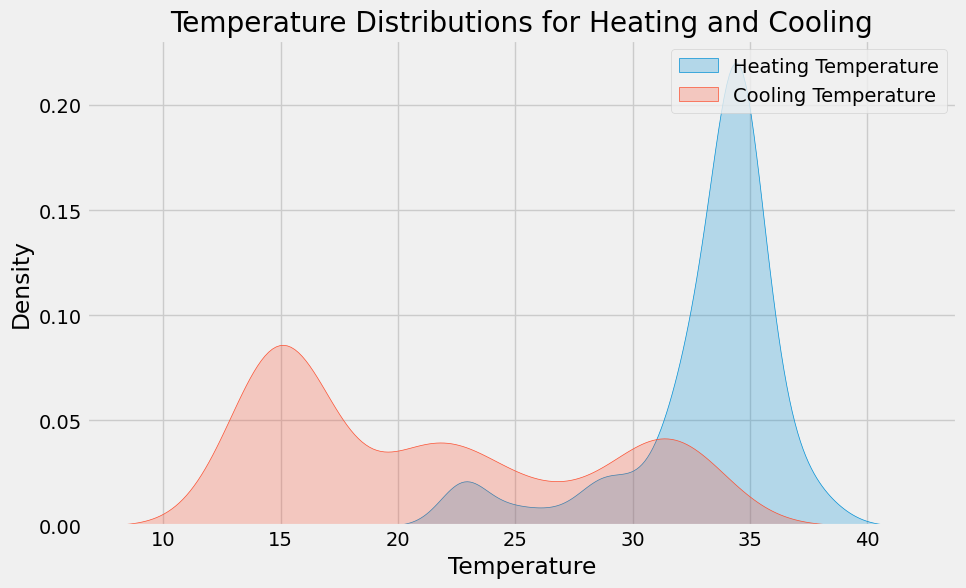

In [68]:
df[df['b_in_kontakt_gewesen']==1].b_gekauft_gesamt.mean()

0.0

In [103]:
df.b_in_kontakt_gewesen

0       1
1       1
2       1
3       1
4       1
       ..
3768    0
3769    0
3770    0
3771    0
3772    0
Name: b_in_kontakt_gewesen, Length: 3772, dtype: int64

In [104]:
df[df['b_in_kontakt_gewesen']==1]

,fakeID,b_specialisation_i,b_specialisation_h,b_specialisation_g,b_specialisation_f,b_specialisation_e,b_specialisation_d,b_specialisation_c,b_specialisation_b,b_specialisation_a,...,q_5th Quint by Total HH,q_2017 Purchasing Power: Per Capita,q_2017 Total Population,"q_2017 Pop 15+/Edu: University, Fachhochschule",q_Uni by Total Pop,q_2017 Personal Care: Per Capita,q_2017 Medical Products: Per Capita,q_2017 Personal Effects: Per Capita,b_in_kontakt_gewesen,b_gekauft_gesamt
0,1069_7334,0,0,0,0,0,0,0,0,0,...,0.186735,23730.35,2194057,324656,0.147971,593.19,326.28,235.75,1,1
1,328_2350,0,0,0,1,1,1,0,0,0,...,0.179848,23343.26,1966798,281130,0.142938,588.54,320.36,230.66,1,1
2,865_6285,0,0,0,1,0,1,0,0,0,...,0.184935,23674.18,2149624,320326,0.149015,592.88,325.57,234.82,1,1
3,47_307,0,1,1,0,0,0,0,0,0,...,0.184523,23572.26,2161445,310981,0.143876,590.84,324.06,233.81,1,0
4,342_2513,0,0,0,0,0,1,0,0,0,...,0.189871,23821.63,2302959,334940,0.145439,593.56,327.75,237.41,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,374_2707,0,1,1,0,1,0,0,0,0,...,0.184994,23629.90,2239711,324823,0.145029,591.94,325.90,234.93,1,1
102,44_1557,1,0,0,1,0,0,0,0,1,...,0.188776,21112.64,40544,1919,0.047331,531.98,309.88,214.83,1,0
103,357_4651,0,0,1,0,0,0,0,0,0,...,0.237642,24451.73,192767,13636,0.070738,579.77,344.32,256.21,1,1
104,343_2515,0,0,0,1,0,0,0,0,0,...,0.190054,23824.51,2310917,336064,0.145425,593.53,327.80,237.49,1,1
